In [2]:
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
from typing import Optional
from typing import Tuple
import seaborn as sns
import numpy as np
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

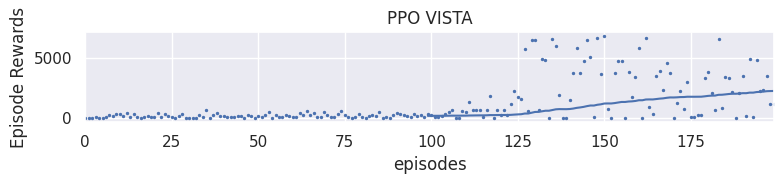

In [3]:
log_dir1 = "/mnt/persistent/lane-follow-ppo/tmp_1"
log_dir2 = "/mnt/persistent/lane-follow-ppo/tmp_2"
log_dir3 = "/mnt/persistent/lane-follow-ppo/tmp_3"
log_dir4 = "/mnt/persistent/lane-follow-ppo/tmp_4"
log_dir7 = "/mnt/persistent/lane-follow-ppo/tmp_7" # took 70 mins to train
timesteps = 500_000
plot_results([
    log_dir1,
    # log_dir2,
    # log_dir3,
    # log_dir4
], timesteps, results_plotter.X_EPISODES, "PPO VISTA")
plt.show()

In [5]:
df1 = pd.read_csv(log_dir1 + "/monitor.csv", header=1).reset_index()
df1['Algorithm'] = 'PPO'
df2 = pd.read_csv(log_dir2 + "/monitor.csv", header=1).reset_index()
df2['Algorithm'] = 'PPO'
df3 = pd.read_csv(log_dir3 + "/monitor.csv", header=1).reset_index()
df3['Algorithm'] = 'PPO'
df4 = pd.read_csv(log_dir4 + "/monitor.csv", header=1).reset_index()
df4['Algorithm'] = 'PPO'
df7 = pd.read_csv(log_dir7 + "/monitor.csv", header=1).reset_index()
df7['Algorithm'] = 'PPO'
df_concat = pd.concat([
    df1, 
    df2, 
    df3,
    df4,
    df7
])
df_concat = df_concat.rename(columns={'index': 'Episode', 'course_completion_rate': 'Course Completion Rate'})
p = sns.lineplot(df_concat, x='Episode', y='')

,Episode,r,l,t,out_of_lane,exceed_max_rot,agent_done,Course Completion Rate,Algorithm
0,0,42.394210,51,13.185602,False,True,False,1.4555,PPO
1,1,42.133823,32,18.664798,False,True,False,1.0561,PPO
2,2,75.728080,86,19.445300,False,True,False,2.4564,PPO
3,3,136.884520,120,25.299627,False,True,False,3.4305,PPO
4,4,73.435930,146,29.858118,True,True,False,4.1762,PPO
...,...,...,...,...,...,...,...,...,...
195,195,648.247000,771,4165.658743,True,False,False,22.3868,PPO
196,196,3430.948000,3010,4171.415259,False,False,False,100.0332,PPO
197,197,14.535642,17,4174.488386,False,True,False,0.5426,PPO
198,198,793.685100,612,4224.124595,False,True,False,14.2425,PPO
